In [51]:
import torch.nn as nn
import torch.nn.functional as F

class NeighborPredictor(nn.Module):
    def __init__(self, input_channels, output_features, num_layers, hidden_dim):
        super(NeighborPredictor, self).__init__()

        self.fc_layers = nn.ModuleList([])

        for i in range(num_layers-1):
            in_feats = input_channels if i==0 else hidden_dim
            self.fc_layers.append(nn.Linear(in_feats, hidden_dim)) 
        
        self.output_fc = nn.Linear(hidden_dim, output_features)
    
    def forward(self, x):
        for layer in self.fc_layers:
            x = F.relu(layer(x))
        x = F.sigmoid(self.output_fc(x))
        return x

In [52]:
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric import datasets,utils


import matplotlib.pyplot as plt

##from modules.heteroGNN import HeteroGNN
from utils import graph_polluters
from tqdm import tqdm, trange

# We initialize conference node features with a single one-vector as feature:
dataset = datasets.DBLP('./data/dblp', transform=T.Constant(node_types='conference'))
data = dataset[0]
data = graph_polluters.remove_edges(data, 0.5, [('author','to','paper')], [('paper','to','author')])

/home/iailab42/kanea0/my-env/lib/python3.10/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(

In [53]:
edge_type = ('author', 'to', 'paper')
from_type, to_type = edge_type[0], edge_type[2]
to_features = []

degrees = utils.degree(data[edge_type].edge_index[0], num_nodes=data[from_type].x.shape[0])
mask = degrees != 0

for i in range(data[from_type].x.shape[0]):
    if degrees[i] == 0:
        continue
    _, edge_index, _, _ = utils.k_hop_subgraph(i, 1, data[edge_type].edge_index, directed=True, flow='target_to_source')
    to_indices = edge_index[0,:]
    to_features.append(torch.mean(data[to_type].x[to_indices], dim=0))
to_features = torch.stack(to_features)#[mask]
from_features = data[from_type].x[mask]
max_dim = max(from_features.shape[1], to_features.shape[1]) 

In [54]:
to_features

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

100%|██████████| 50/50 [00:01<00:00, 32.53it/s]


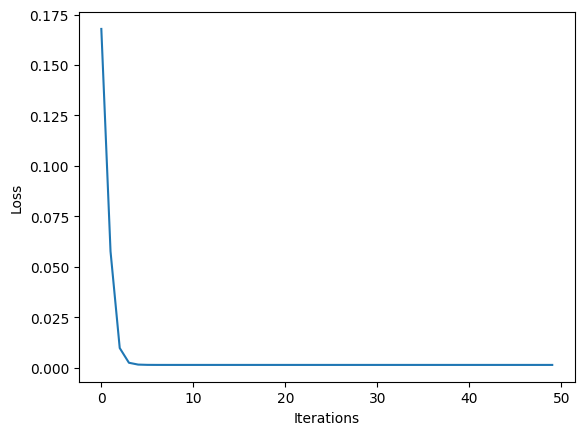

In [55]:
epochs = 50
outputs = []
losses = []
val_losses = []
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from_features = from_features.to(device)
to_features = to_features.to(device)

size = from_features.shape[0]

from_features_train = from_features[:size//2,:]
to_features_train = to_features[:size//2,:]
from_features_val = from_features[size//2:,:]
to_features_val = to_features[size//2:,:]

model = NeighborPredictor(from_features.shape[1], to_features.shape[1], 3, max_dim).to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(from_features)

optimizer = torch.optim.Adam(model.parameters(),
                             weight_decay = 1e-8)

for epoch in trange(epochs):
    prediction = model(from_features_train)
    loss = loss_function(prediction, to_features_train)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Storing the losses in a list for plotting
    losses.append(loss.item())
    
    with torch.no_grad():
        prediction = model(from_features_val)
        loss = loss_function(prediction, to_features_val)
        val_losses.append(loss.item())

 
# plot chart
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(val_losses)

In [56]:
out.shape

torch.Size([3141, 4231])

In [57]:
to_features.shape

torch.Size([3141, 4231])

In [58]:
loss_function(out, to_features)

tensor(0.2501, device='cuda:0')

In [66]:
#connect low-degree nodes to node with features most similar to prediction
degrees = utils.degree(data[edge_type].edge_index[0], num_nodes=data[from_type].x.shape[0])
low_degree_mask = degrees == 0
num_to_nodes = data[to_type].x.shape[0]
low_degree_nodes = data[from_type].x[low_degree_mask]
predictions = model(low_degree_nodes.to(device)).cpu()
for node,prediction,from_index in zip(low_degree_nodes,predictions,low_degree_mask.nonzero()):
    preds_extended = torch.ones((num_to_nodes,1)) @ prediction.unsqueeze(0)
    similarities = torch.cosine_similarity(preds_extended,data[to_type].x)
    print(torch.argmax(similarities, dim=0))
    
    

tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)
tensor(84)

In [ ]:
data[from_type].x[low_degree_mask][0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [ ]:
model(data[from_type].x[low_degree_mask].to(device))[0]

tensor([1.9606e-18, 2.3999e-18, 1.4657e-18,  ..., 3.9491e-18, 1.9398e-18,
        2.2068e-18], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
low_degree_mask.nonzero()

tensor([[   6],
        [  15],
        [  21],
        [  33],
        [  34],
        [  37],
        [  46],
        [  48],
        [  51],
        [  62],
        [  66],
        [  69],
        [ 108],
        [ 109],
        [ 115],
        [ 116],
        [ 122],
        [ 131],
        [ 133],
        [ 138],
        [ 159],
        [ 162],
        [ 166],
        [ 170],
        [ 173],
        [ 177],
        [ 185],
        [ 201],
        [ 208],
        [ 211],
        [ 213],
        [ 216],
        [ 223],
        [ 228],
        [ 237],
        [ 261],
        [ 272],
        [ 275],
        [ 279],
        [ 283],
        [ 291],
        [ 292],
        [ 302],
        [ 311],
        [ 312],
        [ 316],
        [ 323],
        [ 328],
        [ 330],
        [ 343],
        [ 349],
        [ 376],
        [ 426],
        [ 434],
        [ 446],
        [ 448],
        [ 462],
        [ 475],
        [ 482],
        [ 491],
        [ 500],
        [ 507],
        

In [ ]:
torch.mask_in

In [ ]:
a = torch.randn(5)

In [ ]:
a

tensor([ 2.1277,  0.5740, -0.6464, -1.6797,  0.4067])

In [ ]:
b = torch.ones((5)) @ a

In [ ]:
b.shape

torch.Size([])

In [ ]:
a = torch.eye(3)

In [63]:
b = torch.as_tensor([[0., 0., 0.], [1, 1., 0.], [1., 0., 0.]])

In [64]:
c = torch.cosine_similarity(a,b)

In [65]:
torch.argmax(c, dim=0)

tensor(1)